## Imports

In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from os import makedirs, path, listdir, remove
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
from ADMS_functions import PG_index, plot_in_grid_box

## Code

Choose a run:

In [2]:
run = "011"
folder = f"/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/{run}/"
files = [path.join(folder, file) for file in listdir(folder) if path.splitext(file)[-1]==".nc"]
griddings = [path.join(folder, item) for item in listdir(folder) if path.isdir(path.join(folder, item)) and item.split("_")[0]=="gridded"]
print(f"We have {len(griddings)} folder(s) with gridded data:")
for i, grid in enumerate(griddings):
    print(i, grid.split("/")[-1])

We have 1 folder(s) with gridded data:
0 gridded_151


Choose a folder and pollutant species:

In [3]:
coordinate_system = griddings[-1] # "gridded****" or "raw_latlon"
variable = "NO2"

if coordinate_system == "raw_latlon":
    filepath = path.join(folder, "raw_processed_coordinates.nc")
else:
    filepath = path.join(folder, f"{coordinate_system}/", f"{variable}_PG_classes_grid.nc")

ds = xr.open_dataset(filepath)

Choose a Pasquill-Gifford class:

In [10]:
choose_PG_class = "G"

da = ds.isel(PG_class=PG_index.index(choose_PG_class))[variable]
# da = ds[variable][:, :, PG_index.index(choose_PG_class)]
array = np.rot90(da.values)
print(f"The chosen data array has shape {array.shape}.")

The chosen data array has shape (85, 152).


Fill the edge NaN values:

In [11]:
print("Before: ", np.sum(np.isnan(array)), f"NaN values ({(np.sum(np.isnan(array)) / np.prod(array.shape) * 100).round(1)}%)")
array[np.isnan(array)] = 0
print("After: ", np.sum(np.isnan(array)), "NaN values")

Before:  1138 NaN values (8.8%)
After:  0 NaN values


Plot the gridded data!

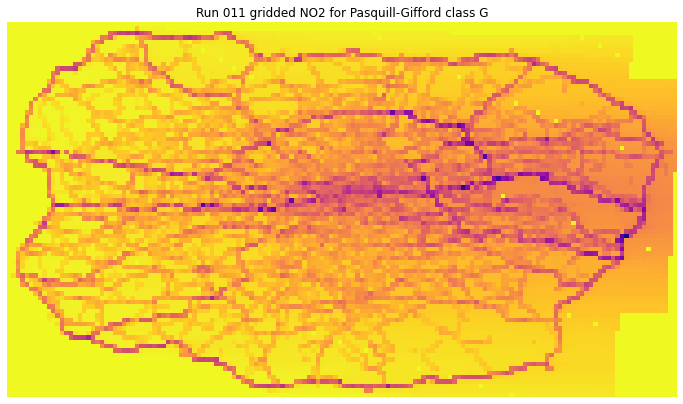

In [12]:
fig, ax = plt.subplots(figsize=(12,7))
ax.imshow(array, cmap="plasma_r")
ax.axis("off")
plt.title(f"Run {run} gridded {variable} for Pasquill-Gifford class {choose_PG_class}")
plt.show()

Now we perform singular value decomposition (SVD):

In [13]:
U, S, Vt = np.linalg.svd(array) # default is full_matrices=True
# print(U.shape, S.shape, Vt.shape)

# Turn the S vector into a diagonal matrix
S_matrix = np.zeros((U.shape[1], Vt.shape[0]))
S_matrix[:np.diag(S).shape[0], :np.diag(S).shape[1]] = np.diag(S)
print(f"Our matrices have shapes \nU {U.shape}\nS {S_matrix.shape}\nVt {Vt.shape}.")

# Does U . S_matrix . Vt = array ?
if np.allclose(array, np.dot(U, np.dot(S_matrix, Vt))):
    print("SVD worked!")

Our matrices have shapes 
U (85, 85)
S (85, 152)
Vt (152, 152).
SVD worked!


Plot the SVD:

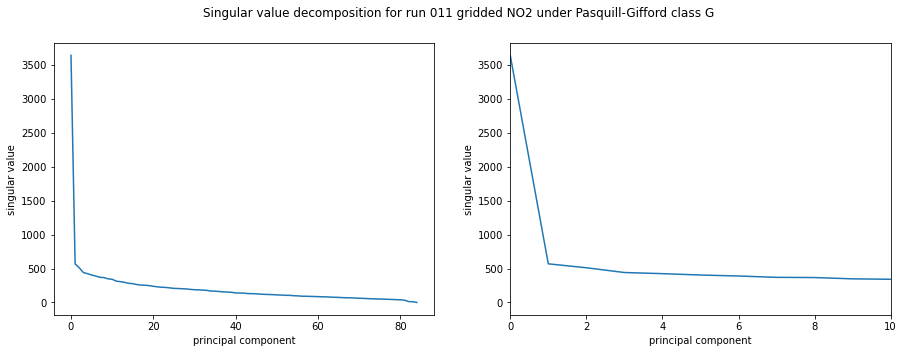

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
for ax in (ax1, ax2):
    ax.plot(S)
    ax.set_xlabel("principal component")
    ax.set_ylabel("singular value")
ax2.set_xlim((0, 10))
fig.suptitle(f"Singular value decomposition for run {run} gridded {variable} under Pasquill-Gifford class {choose_PG_class}")
plt.show()

Want to plot a single principal component?

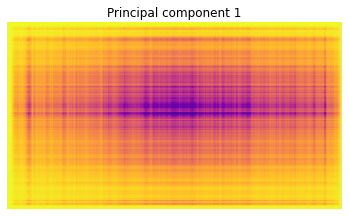

In [146]:
# Plot a principal component
choose = 1
component = np.dot(U[:, :choose], np.dot(S_matrix[:choose, :choose], Vt[:choose, :]))
plt.imshow(component, cmap="plasma_r")
plt.title(f"Principal component {choose}")
plt.axis("off")
plt.show()

Specify a list of principal components to plot together:

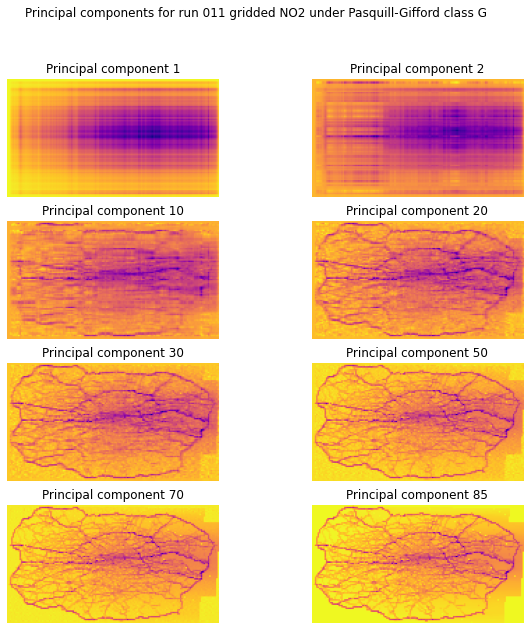

In [15]:
PCs_to_plot = [1, 2, 10, 20, 30, 50, 70, 85]
rows = 4
columns = 2

if rows * columns == len(PCs_to_plot):
    fig, axs = plt.subplots(rows, columns, figsize=(10,10))
    axs = axs.ravel()

    for i in range(len(axs)):
        PC = PCs_to_plot[i]
        component = np.dot(U[:, :PC], np.dot(S_matrix[:PC, :PC], Vt[:PC, :]))
        axs[i].imshow(component, cmap="plasma_r")
        axs[i].set_title(f"Principal component {PC}")
        axs[i].axis("off")
    fig.suptitle(f"Principal components for run {run} gridded {variable} under Pasquill-Gifford class {choose_PG_class}")
    plt.show()
elif not rows * columns == len(PCs_to_plot):
    print("The number of plots doesn't match the rows and columns specified.")